# Preparation

In [146]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Accuracy
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from keras.callbacks import Callback

In [147]:
# load loan data
df = pd.read_csv('loan_data.csv')
df.head(5)

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int_rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log_annual_inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days_with_cr_line  9578 non-null   float64
 8   revol_bal          9578 non-null   int64  
 9   revol_util         9578 non-null   float64
 10  inq_last_6mths     9578 non-null   int64  
 11  delinq_2yrs        9578 non-null   int64  
 12  pub_rec            9578 non-null   int64  
 13  not_fully_paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


# Check null values and duplicate records

In [149]:
# Check null vallues
df.isnull().sum()

credit_policy        0
purpose              0
int_rate             0
installment          0
log_annual_inc       0
dti                  0
fico                 0
days_with_cr_line    0
revol_bal            0
revol_util           0
inq_last_6mths       0
delinq_2yrs          0
pub_rec              0
not_fully_paid       0
dtype: int64

## There is no null value

In [150]:
# Check duplicate records
print(df.duplicated().sum())

0


## There are no duplicate records

# One-hot encoding of purpose

In [151]:
# One-hot encoding of purpose
df = pd.get_dummies(df, columns=['purpose'], drop_first=True, dtype=int)
df.head(5)

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,1,0,0,0,0,0


# Check correlation

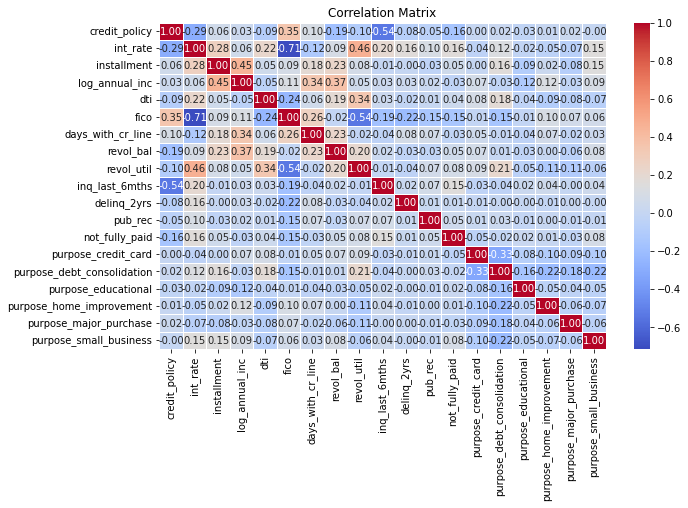

In [152]:
# Correlation matrix
correlation_matrix = df.corr()
# Visualize the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linecolor='white', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()



## Columns to drop: int_rate, credit_policy, revol_util

### There is a strong correlation between fico and in_rate, therefore int_rate will be dropped
### There is a significant correlation between credit_policy and inq_last_6months. Plus, credit_policy is an already an outcome of an underwriting evaluation by LendingClub.com which may skew our model. So credit_policy will be dropped
### There is a significant correlation between revol_util and fico. revol_util will be dropped

In [153]:
# drop int_rate
df.drop(columns=['int_rate', 'credit_policy', 'revol_util'], inplace=True)

In [154]:
df.head(5)

,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,829.10,11.350407,19.48,737,5639.958333,28854,0,0,0,0,0,1,0,0,0,0
1,228.22,11.082143,14.29,707,2760.000000,33623,0,0,0,0,1,0,0,0,0,0
2,366.86,10.373491,11.63,682,4710.000000,3511,1,0,0,0,0,1,0,0,0,0
3,162.34,11.350407,8.10,712,2699.958333,33667,1,0,0,0,0,1,0,0,0,0
4,102.92,11.299732,14.97,667,4066.000000,4740,0,1,0,0,1,0,0,0,0,0


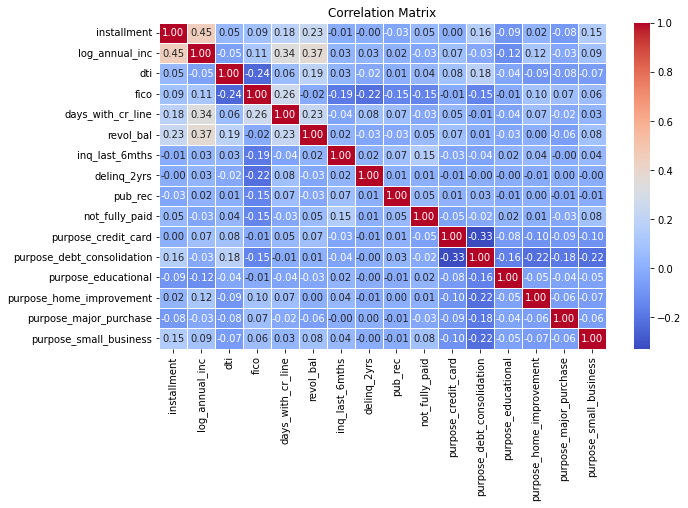

In [155]:
# Correlation matrix
correlation_matrix = df.corr()
# Visualize the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linecolor='white', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Create model

## Prepare data for training

In [156]:
df.head(5)

,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,829.10,11.350407,19.48,737,5639.958333,28854,0,0,0,0,0,1,0,0,0,0
1,228.22,11.082143,14.29,707,2760.000000,33623,0,0,0,0,1,0,0,0,0,0
2,366.86,10.373491,11.63,682,4710.000000,3511,1,0,0,0,0,1,0,0,0,0
3,162.34,11.350407,8.10,712,2699.958333,33667,1,0,0,0,0,1,0,0,0,0
4,102.92,11.299732,14.97,667,4066.000000,4740,0,1,0,0,1,0,0,0,0,0


In [157]:
df.columns

Index(['installment', 'log_annual_inc', 'dti', 'fico', 'days_with_cr_line',
       'revol_bal', 'inq_last_6mths', 'delinq_2yrs', 'pub_rec',
       'not_fully_paid', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement',
       'purpose_major_purchase', 'purpose_small_business'],
      dtype='object')

In [158]:
# Create model
X = df.drop(columns=['not_fully_paid'])
y = df['not_fully_paid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# scaler = MinMaxScaler()
scaler = StandardScaler()

# Scale features
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [159]:
X_train

,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,inq_last_6mths,delinq_2yrs,pub_rec,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,0.049122,-1.535031,-0.172101,-0.498260,0.268636,-0.520199,-0.266751,-0.298831,-0.239131,-0.388102,-0.832847,-0.190014,-0.263089,4.497152,-0.25967
1,-0.391757,0.475451,-0.948919,0.811133,-0.566438,-0.388802,-0.714472,-0.298831,-0.239131,2.576642,-0.832847,-0.190014,-0.263089,-0.222363,-0.25967
2,-0.865503,0.385937,-0.837116,0.156437,-0.302347,-0.144915,-0.266751,-0.298831,-0.239131,-0.388102,1.200701,-0.190014,-0.263089,-0.222363,-0.25967
3,1.015832,0.203709,-0.616412,0.549255,-0.194484,0.805094,-0.714472,-0.298831,-0.239131,-0.388102,-0.832847,-0.190014,-0.263089,-0.222363,-0.25967
4,-0.024503,-0.393163,0.935774,1.203951,0.992200,-0.514108,-0.266751,-0.298831,-0.239131,-0.388102,-0.832847,-0.190014,-0.263089,4.497152,-0.25967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7657,-0.713606,-0.835953,-0.273740,-0.891078,0.249058,-0.519088,0.180970,1.498378,-0.239131,-0.388102,1.200701,-0.190014,-0.263089,-0.222363,-0.25967
7658,2.366641,0.216416,1.783740,-0.236381,2.334710,0.452397,-0.266751,-0.298831,-0.239131,-0.388102,1.200701,-0.190014,-0.263089,-0.222363,-0.25967
7659,1.951514,0.138007,0.908186,-0.498260,0.356905,0.046882,-0.714472,-0.298831,-0.239131,-0.388102,1.200701,-0.190014,-0.263089,-0.222363,-0.25967
7660,-0.335800,0.111011,0.961910,-0.629199,-0.014667,0.038158,-0.266751,-0.298831,-0.239131,-0.388102,1.200701,-0.190014,-0.263089,-0.222363,-0.25967


In [160]:
X_test

,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,inq_last_6mths,delinq_2yrs,pub_rec,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,0.659518,-0.551198,0.279471,-1.414835,-0.302347,-0.253694,0.628691,-0.298831,-0.239131,-0.388102,1.200701,-0.190014,-0.263089,-0.222363,-0.259670
1,1.046473,0.362771,-0.247604,0.549255,-0.386254,-0.019038,0.628691,-0.298831,-0.239131,-0.388102,1.200701,-0.190014,-0.263089,-0.222363,-0.259670
2,-0.578554,-0.956987,0.164763,-0.498260,-0.997593,-0.075759,-0.714472,-0.298831,-0.239131,2.576642,-0.832847,-0.190014,-0.263089,-0.222363,-0.259670
3,-1.021902,0.111011,2.259996,-1.022017,0.764486,-0.275868,1.076412,1.498378,-0.239131,-0.388102,-0.832847,-0.190014,-0.263089,-0.222363,-0.259670
4,-0.761673,0.315524,-1.249483,-0.236381,0.189107,-0.509921,-0.266751,1.498378,-0.239131,-0.388102,-0.832847,-0.190014,-0.263089,-0.222363,-0.259670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1911,-0.792507,-0.551198,1.634185,0.549255,-0.884119,-0.118363,-0.714472,-0.298831,-0.239131,-0.388102,1.200701,-0.190014,-0.263089,-0.222363,-0.259670
1912,-0.493215,-0.905462,1.401865,0.287376,-0.218440,-0.473883,-0.714472,-0.298831,-0.239131,-0.388102,1.200701,-0.190014,-0.263089,-0.222363,-0.259670
1913,-0.725756,0.177577,-0.529292,-0.629199,-0.709895,-0.406440,-0.266751,-0.298831,-0.239131,-0.388102,-0.832847,-0.190014,-0.263089,-0.222363,-0.259670
1914,-0.281101,-1.801774,-0.816788,-0.367320,-1.572954,-0.385820,-0.714472,-0.298831,-0.239131,-0.388102,1.200701,-0.190014,-0.263089,-0.222363,-0.259670


In [161]:
# Print shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7662, 15)
X_test shape: (1916, 15)
y_train shape: (7662,)
y_test shape: (1916,)


## Check and fix class imbalance

Class distribution in y_train:
0    6434
1    1228
Name: not_fully_paid, dtype: int64


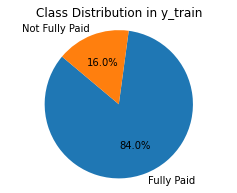

In [162]:
# check for class imbalance
print("Class distribution in y_train:")
print(y_train.value_counts())

# Create pie charts for class distribution in y_train
plt.figure(figsize=(4, 3))
plt.pie(y_train.value_counts(), labels=['Fully Paid', 'Not Fully Paid'], autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution in y_train')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is a circle.
plt.show()

Class distribution in y_train:
0    6434
1    6434
Name: not_fully_paid, dtype: int64


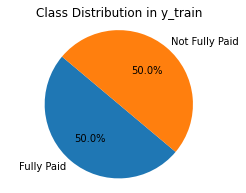

In [163]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Class distribution in y_train:")
print(y_train.value_counts())

# Create pie charts for class distribution in y_train
plt.figure(figsize=(4, 3))
plt.pie(y_train.value_counts(), labels=['Fully Paid', 'Not Fully Paid'], autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution in y_train')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is a circle.
plt.show()

In [164]:
# # Check class distribution after SMOTE
# print("Class distribution in y_test:")
# print(y_test.value_counts())

# # Create pie charts for class distribution in y_test
# plt.figure(figsize=(4, 3))
# plt.pie(y_test.value_counts(), labels=['Fully Paid', 'Not Fully Paid'], autopct='%1.1f%%', startangle=140)
# plt.title('Class Distribution in y_test')
# plt.axis('equal')  # Equal aspect ratio ensures that pie chart is a circle.
# plt.show()

## Create a neural network model

In [165]:
# Set hyperparameters of neural network
input_dim = X_train.shape[1]  # Number of features
hidden_layer_activation = 'relu'  # Activation function for hidden layer
output_activation = 'sigmoid'  # Activation function for output layer
output_neurons = 1  # Number of output neurons for binary classification
optimizer = Adam(learning_rate=0.0005)  # Optimizer with learning rate
loss_function = 'binary_crossentropy'  # Loss function for binary classification
metrics = ['accuracy', Recall()]  # Metrics to evaluate the model
epochs = 1000  # Number of epochs for training
batch_size = 32  # Batch size for training
learning_rate = 0.001  # Learning rate for the optimizer

In [166]:
# input_dim, hidden_layer_activation, output_activation, output_neurons, optimizer, loss_function, metrics, epochs, batch_size

In [167]:
# Create neural network model
model = Sequential(
    [
        Input(shape=(input_dim,)),
        Dense(128, activation=hidden_layer_activation),
        # Dropout(0.2),  # Dropout layer to prevent overfitting
        Dense(64, activation=hidden_layer_activation),
        #Dense(32, activation=hidden_layer_activation),
        Dense(output_neurons, activation=output_activation)
    ]
)

In [168]:
# Compile the model
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

In [169]:
# Display model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               2048      
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10369 (40.50 KB)
Trainable params: 10369 (40.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Create epoch logger

In [170]:
# Epoch logger callback
class EpochLogger(Callback):
    def __init__(self, interval=10):
        super().__init__()
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            log_str = f"Epoch {epoch + 1}: " + ", ".join(
                [f"{k}: {v:.4f}" for k, v in logs.items()]
            )
            print(log_str)

## Define early stopping callbacks

In [171]:
## Define early stopping callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

## Train neural network

In [172]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=0,
    callbacks=[
        EpochLogger(interval=10),
        early_stopping
    ]
)

Epoch 10: loss: 0.5467, accuracy: 0.7140, recall_3: 0.4604, val_loss: 0.8652, val_accuracy: 0.3974, val_recall_3: 0.3974
Epoch 20: loss: 0.4986, accuracy: 0.7478, recall_3: 0.5487, val_loss: 0.8014, val_accuracy: 0.4685, val_recall_3: 0.4685
Epoch 30: loss: 0.4556, accuracy: 0.7784, recall_3: 0.6238, val_loss: 0.6577, val_accuracy: 0.6049, val_recall_3: 0.6049
Epoch 40: loss: 0.4177, accuracy: 0.8073, recall_3: 0.6728, val_loss: 0.6790, val_accuracy: 0.5952, val_recall_3: 0.5952
Epoch 50: loss: 0.3836, accuracy: 0.8232, recall_3: 0.7132, val_loss: 0.5688, val_accuracy: 0.6838, val_recall_3: 0.6838
Epoch 60: loss: 0.3535, accuracy: 0.8473, recall_3: 0.7593, val_loss: 0.6415, val_accuracy: 0.6445, val_recall_3: 0.6445
Epoch 70: loss: 0.3319, accuracy: 0.8611, recall_3: 0.7873, val_loss: 0.5002, val_accuracy: 0.7475, val_recall_3: 0.7475
Epoch 80: loss: 0.3034, accuracy: 0.8722, recall_3: 0.8036, val_loss: 0.5068, val_accuracy: 0.7428, val_recall_3: 0.7428
Epoch 90: loss: 0.2836, accuracy

## Check training results

In [173]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'recall_3', 'val_loss', 'val_accuracy', 'val_recall_3'])

In [174]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_recall = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Recall: {test_recall:.4f}")

60/60 [==============================] - 0s 714us/step - loss: 1.0438 - accuracy: 0.7004 - recall_3: 0.3607
Test Loss: 1.0438, Test Accuracy: 0.7004, Test Recall: 0.3607


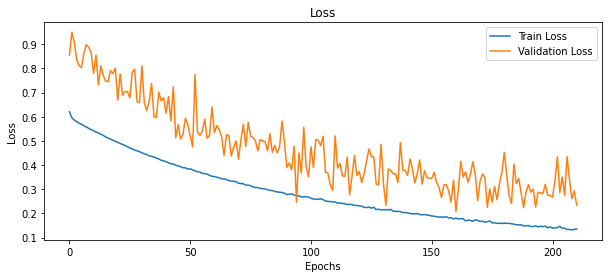

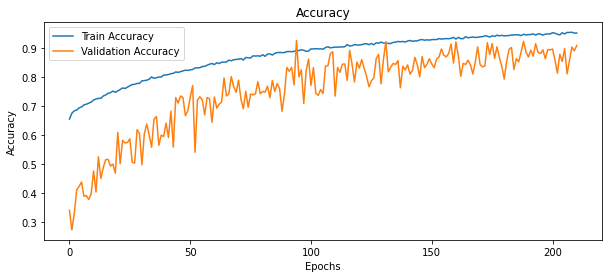

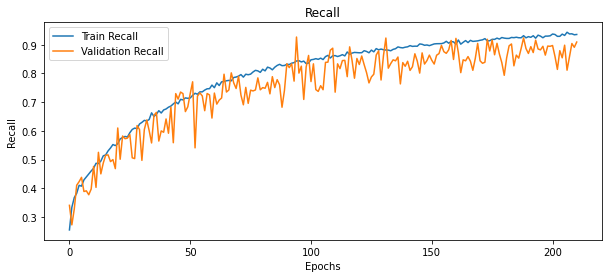

In [175]:
# Get values from history
train_loss = history.history[list(history.history.keys())[0]]
train_accuracy = history.history[list(history.history.keys())[1]]
train_recall = history.history[list(history.history.keys())[2]]
val_loss = history.history[list(history.history.keys())[3]]
val_accuracy = history.history[list(history.history.keys())[4]]
val_recall = history.history[list(history.history.keys())[5]]

list(history.history.keys())[4]
# Plot Loss, Accuracy and Recall in three subplots
#plt.figure(figsize=(14, 4))

# Loss plot
#plt.subplot(1, 3, 1)
plt.figure(figsize=(10, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy plot
#plt.subplot(1, 3, 2)
plt.figure(figsize=(10, 4))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Recall plot
#plt.subplot(1, 3, 3)
plt.figure(figsize=(10, 4))
plt.plot(train_recall, label='Train Recall')
plt.plot(val_recall, label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

# plt.tight_layout()
# plt.show()

## Review metrics

In [176]:
def classification_model_metrics(model, model_name, y_train, y_test):
    # Predict probabilities for ROC curve
    y_train_pred_prob = model.predict(X_train).ravel()
    y_test_pred_prob = model.predict(X_test).ravel()

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
    roc_auc = auc(fpr, tpr)
     
    # Compute Youden's J statistic for each threshold
    youden_j = tpr - fpr
    optimal_threshold_index = np.argmax(youden_j)
    optimal_threshold = thresholds[optimal_threshold_index]
    
    # Calculate predictions for training and test sets
    y_train_pred = (y_train_pred_prob > optimal_threshold).astype("int32")
    y_test_pred = (y_test_pred_prob > optimal_threshold).astype("int32")
    
    # Calculate metrics
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_score_train = precision_score(y_train, y_train_pred, average='weighted')
    precision_score_test = precision_score(y_test, y_test_pred, average='weighted')
    recall_score_train = recall_score(y_train, y_train_pred, average='weighted')
    recall_score_test = recall_score(y_test, y_test_pred, average='weighted')
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')    

    # Confusion matrix and classification report
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    class_report = classification_report(y_test, y_test_pred)

    # Plot ROC curve with the optimal threshold marked
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    #plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], color='red', label="Optimal Threshold")
    plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], color='red', marker='o', label=f'Optimal Threshold = {optimal_threshold:.4f}')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    #plt.legend()
    plt.legend(loc='lower right')
    plt.show()

    # Create a DataFrame to hold the results
    classification_metrics_df = pd.DataFrame({
        'Model': [model_name],
        'Accuracy (Train)': [accuracy_train],
        'Accuracy (Test)': [accuracy_test],
        'Precision Score (Train)': [precision_score_train],
        'Precision Score (Test)': [precision_score_test],
        'Recall Score (Train)': [recall_score_train],
        'Recall Score (Test)': [recall_score_test],
        'F1 Score (Train)': [f1_train],
        'F1 Score (Test)': [f1_test],
        'AUC': [roc_auc],
        "Youden's J": [youden_j[optimal_threshold_index]],
        "Optimal Threshold Index": [optimal_threshold_index],
        "Optimal Threshold": [optimal_threshold]
    })

    # Print the metrics
    print(classification_metrics_df.T)

    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

    return classification_metrics_df

60/60 [==============================] - 0s 577us/step


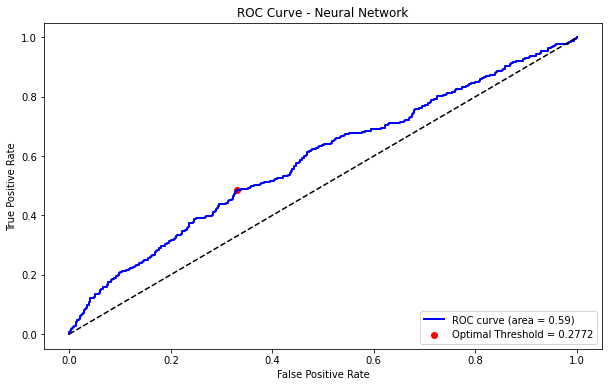

                                      0
Model                    Neural Network
Accuracy (Train)               0.884287
Accuracy (Test)                0.639875
Precision Score (Train)         0.89979
Precision Score (Test)         0.767881
Recall Score (Train)           0.884287
Recall Score (Test)            0.639875
F1 Score (Train)               0.883154
F1 Score (Test)                0.684667
AUC                            0.586421
Youden's J                     0.155016
Optimal Threshold Index             226
Optimal Threshold              0.277231

Confusion Matrix:
[[1079  532]
 [ 158  147]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.67      0.76      1611
           1       0.22      0.48      0.30       305

    accuracy                           0.64      1916
   macro avg       0.54      0.58      0.53      1916
weighted avg       0.77      0.64      0.68      1916



,Model,Accuracy (Train),Accuracy (Test),Precision Score (Train),Precision Score (Test),Recall Score (Train),Recall Score (Test),F1 Score (Train),F1 Score (Test),AUC,Youden's J,Optimal Threshold Index,Optimal Threshold
0,Neural Network,0.884287,0.639875,0.89979,0.767881,0.884287,0.639875,0.883154,0.684667,0.586421,0.155016,226,0.277231


In [177]:
classification_metrics_df = classification_model_metrics(model, "Neural Network", y_train, y_test)
classification_metrics_df

# Conclusion

# Conclusion
# Columns dropped: int_rate, credit_policy, revol_util
# Class imbalance handled using SMOTE
# Model: Neural Network with 2 hidden layers (128 and 64 neurons)
# The model is volatile, with high variance in accuracy and recall across epochs and the results depend on the random parameters selected in the beginning.
# Attenpted different configurations:
    # Scaler: StandardScaler vs MinMaxScaler
    # Optimizer: Adam with different learning rates
    # Epochs: 50, 100, 200, 500, 1000, 2000, 5000
# I calculated the optimal threshold using Youden's J statistic. The default threshold of 0.5 was not optimal for this model, as it resulted in a low recall.
# Our objective was to achieve a recall of 0.8 or higher, but the model did not meet this requirement.
# The results here show a test recall and a test accuracy of 0.64 both